In [1]:
import re
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Banglish.csv',encoding= 'unicode_escape')

In [3]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["labels"] = lb_make.fit_transform(df["Emotion"])
df[["Emotion", "labels"]].head(11)


,Emotion,labels
0,surprise,5
1,happy,3
2,happy,3
3,angry,0
4,fear,2
5,disgust,1
6,surprise,5
7,angry,0
8,surprise,5
9,happy,3


In [4]:
test_df=df.sample(frac=0.2,random_state=200)
train_df=df.drop(test_df.index)

In [5]:
train_df.head()

,Unnamed: 0,Emotion,text,labels
0,4615,surprise,varoter senaprdhan pac diner sfre dhakay,5
2,5060,happy,prithibite bangladesher mukh,3
3,3115,angry,motrsaikel seba calu ba bikolpo kormosngsthane...,0
5,484,disgust,bzaparta kharap hobena dese trun smajer bisal...,1
7,6408,angry,beyadb sob bysei keyadb,0


In [6]:
#checking for ull values
train_df.info()
print()
test_df.info()
print()
#val_df.info()
#print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2435 entries, 0 to 3043
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2435 non-null   int64 
 1   Emotion     2435 non-null   object
 2   text        2435 non-null   object
 3   labels      2435 non-null   int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 85.6+ KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 570 to 507
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  609 non-null    int64 
 1   Emotion     609 non-null    object
 2   text        609 non-null    object
 3   labels      609 non-null    int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 21.4+ KB



In [7]:
train_df["Emotion"].value_counts()

surprise    425
happy       421
sad         412
fear        402
angry       391
disgust     384
Name: Emotion, dtype: int64

In [8]:
test_df["Emotion"].value_counts()

surprise    112
happy       109
sad         103
angry       100
disgust      93
fear         92
Name: Emotion, dtype: int64

In [9]:
#sample text from dataset
sample = train_df["text"]
print(sample)

0                varoter senaprdhan pac diner sfre dhakay
2                            prithibite bangladesher mukh
3       motrsaikel seba calu ba bikolpo kormosngsthane...
5       bzaparta kharap hobena  dese trun smajer bisal...
7                                 beyadb sob bysei keyadb
                              ...                        
3038    amader poray sob sangbadik o buddhijibi ze tra...
3039    mmotoa bndzopadhzayke abar sokj kore agamikal ...
3040                                 vai amra ki manush ?
3041                           ke bllo BNP kharap ache ??
3043                  vai eida deikha kichu lage na? ????
Name: text, Length: 2435, dtype: object


In [10]:
x_train, x_test, y_train, y_test = train_df["text"], test_df["text"], train_df["labels"], test_df["labels"]

In [11]:
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras import layers
from keras.models import Sequential

EPOCHS= 35
act= "swish"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

In [12]:
#converting text to vectors via tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
TEST = tokenizer.texts_to_sequences(test_df["text"]) 

vocab_size = len(tokenizer.word_index) + 1 

In [13]:
#calculating max length of the vector
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 114


In [14]:
#Zero padding every vector so that they are the same size
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
TEST = pad_sequences(TEST, padding='post', maxlen=maxlen)

In [15]:
#One Hot Encoding integer labels
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_train = np_utils.to_categorical(y_train)

In [16]:
#reading fasttext
def get_embedding_vectors(tokenizer, dim=300):
    embedding_index = {}
    with open('glove.840B.300d.txt','r', encoding="cp437", errors='ignore') as f:
        for line in tqdm.tqdm(f, "Reading Glove"):
            values = line.split()
            word = ''.join(values[:-300])
            vectors = np.asarray(values[-300:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
          
    return embedding_matrix

In [17]:
embedding_matrix = get_embedding_vectors(tokenizer)

Reading Glove: 2196018it [06:26, 5680.71it/s]


In [18]:
#defining CNN-BiLSTM model
embedding_dim = 300

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights = [embedding_matrix], input_length=maxlen))
model.add(layers.Dropout(0.3)) 
model.add(layers.Conv1D(filters=64, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256,activation=act)) 
model.add(layers.Dropout(0.3)) 
model.add(layers.Dense(6, activation="softmax"))
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 114, 300)          2313300   
                                                                 
 dropout (Dropout)           (None, 114, 300)          0         
                                                                 
 conv1d (Conv1D)             (None, 112, 64)           57664     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 37, 64)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 37, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 64)            12352     
                                                        

In [19]:
checkpoint_filepath = './Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='test_accuracy',
    mode='max',
    save_best_only=True)

In [20]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=1, validation_data=(X_test, dummy_y_test), batch_size=8, callbacks=[model_checkpoint_callback]) 
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/35
305/305 [==============================] - 99s 210ms/step - loss: 1.7896 - accuracy: 0.1934 - val_loss: 1.7676 - val_accuracy: 0.2430
Epoch 2/35
305/305 [==============================] - 56s 183ms/step - loss: 1.7281 - accuracy: 0.2706 - val_loss: 1.6913 - val_accuracy: 0.2660
Epoch 3/35
305/305 [==============================] - 57s 187ms/step - loss: 1.4783 - accuracy: 0.4209 - val_loss: 1.5382 - val_accuracy: 0.3875
Epoch 4/35
305/305 [==============================] - 56s 182ms/step - loss: 1.1099 - accuracy: 0.5840 - val_loss: 1.5619 - val_accuracy: 0.4269
Epoch 5/35
305/305 [==============================] - 57s 186ms/step - loss: 0.7872 - accuracy: 0.7138 - val_loss: 1.6510 - val_accuracy: 0.4466
Epoch 6/35
305/305 [==============================] - 57s 188ms/step - loss: 0.5836 - accuracy: 0.7979 - val_loss: 1.9884 - val_accuracy: 0.4762
Epoch 7/35
305/305 [==============================] - 56s 185ms/step - loss: 0.4399 - accuracy: 0.8398 - val_loss: 1.9125 - val_ac

305/305 [==============================] - 36s 117ms/step - loss: 0.0533 - accuracy: 0.9832 - val_loss: 3.4041 - val_accuracy: 0.5057
Epoch 28/35
305/305 [==============================] - 36s 117ms/step - loss: 0.0720 - accuracy: 0.9774 - val_loss: 3.0563 - val_accuracy: 0.4811
Epoch 29/35
305/305 [==============================] - 33s 108ms/step - loss: 0.0775 - accuracy: 0.9729 - val_loss: 3.0290 - val_accuracy: 0.4926
Epoch 30/35
305/305 [==============================] - 34s 110ms/step - loss: 0.0710 - accuracy: 0.9762 - val_loss: 3.2078 - val_accuracy: 0.5008
Epoch 31/35
305/305 [==============================] - 33s 108ms/step - loss: 0.0744 - accuracy: 0.9782 - val_loss: 3.1805 - val_accuracy: 0.4926
Epoch 32/35
305/305 [==============================] - 34s 112ms/step - loss: 0.0739 - accuracy: 0.9741 - val_loss: 3.0809 - val_accuracy: 0.4943
Epoch 33/35
305/305 [==============================] - 33s 108ms/step - loss: 0.0511 - accuracy: 0.9807 - val_loss: 3.5404 - val_accurac

In [21]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

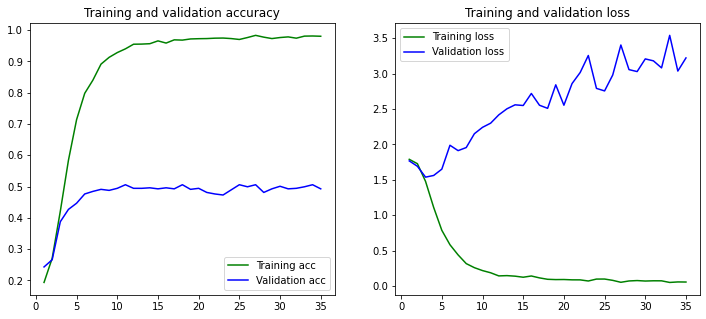

In [22]:
PlotGraph(history)

In [23]:
print(f"Best Accuracy Achieved by Model: {max(history.history['val_accuracy'])}")

Best Accuracy Achieved by Model: 0.5057471394538879


In [24]:
predict = model.predict(TEST)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

array([5, 1, 2, 2, 5, 1, 4, 5, 5, 4, 5, 0, 0, 5, 4, 5, 0, 0, 1, 1, 4, 2,
       4, 4, 5, 5, 0, 1, 5, 5, 1, 1, 2, 0, 1, 3, 1, 4, 1, 4, 2, 2, 2, 3,
       4, 5, 0, 4, 2, 4, 5, 3, 3, 3, 4, 5, 5, 4, 2, 4, 0, 5, 4, 2, 4, 1,
       0, 5, 5, 3, 4, 4, 4, 3, 2, 0, 2, 5, 3, 5, 1, 5, 5, 3, 2, 1, 1, 2,
       3, 3, 2, 4, 1, 5, 3, 3, 2, 3, 3, 4, 3, 5, 0, 2, 3, 5, 5, 5, 5, 1,
       2, 5, 5, 1, 4, 3, 4, 1, 2, 1, 3, 3, 0, 5, 0, 2, 1, 4, 1, 4, 2, 5,
       1, 5, 3, 2, 1, 4, 2, 2, 0, 2, 1, 5, 1, 2, 1, 0, 3, 2, 4, 2, 2, 3,
       4, 3, 3, 5, 0, 0, 2, 0, 1, 5, 2, 4, 3, 2, 0, 2, 2, 4, 3, 5, 3, 3,
       5, 4, 4, 0, 5, 4, 5, 2, 2, 5, 5, 2, 1, 4, 4, 3, 3, 5, 5, 5, 5, 2,
       4, 5, 1, 1, 5, 4, 4, 3, 5, 2, 1, 4, 5, 2, 4, 5, 2, 0, 5, 1, 3, 4,
       3, 2, 5, 4, 3, 4, 4, 3, 0, 2, 4, 3, 3, 4, 3, 2, 3, 2, 1, 5, 2, 1,
       5, 0, 4, 4, 5, 3, 4, 1, 5, 3, 0, 4, 5, 2, 2, 3, 2, 0, 2, 4, 1, 3,
       5, 4, 5, 3, 3, 3, 5, 2, 5, 3, 5, 5, 4, 0, 4, 3, 3, 4, 4, 5, 5, 2,
       4, 5, 4, 3, 3, 2, 2, 3, 3, 0, 5, 1, 3, 5, 2,

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_df["labels"], predict_class)
cm

array([[36,  8,  7,  7, 20, 22],
       [ 9, 46, 12,  5, 10, 11],
       [ 7,  4, 49,  6, 14, 12],
       [ 5,  7,  8, 63, 11, 15],
       [ 7, 11,  7, 16, 40, 22],
       [ 4,  4, 15, 13, 10, 66]], dtype=int64)

<AxesSubplot:>

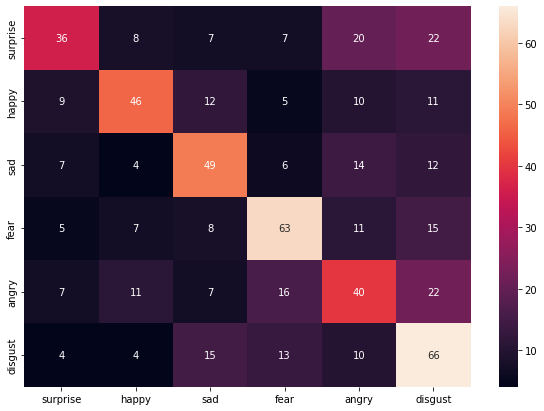

In [26]:
df_cm = pd.DataFrame(cm, index=["surprise","happy","sad", "fear", "angry","disgust"], columns=["surprise","happy","sad", "fear", "angry","disgust"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")

In [27]:
from sklearn.metrics import classification_report

print(classification_report(test_df["labels"], predict_class, target_names =["anger", "fear", "joy", "disgust", "sadness", "surprise"]))

              precision    recall  f1-score   support

       anger       0.53      0.36      0.43       100
        fear       0.57      0.49      0.53        93
         joy       0.50      0.53      0.52        92
     disgust       0.57      0.58      0.58       109
     sadness       0.38      0.39      0.38       103
    surprise       0.45      0.59      0.51       112

    accuracy                           0.49       609
   macro avg       0.50      0.49      0.49       609
weighted avg       0.50      0.49      0.49       609

